In [1]:
import cv2
import torch
import mediapipe as mp
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=(3,3,3), stride=(1,1,1), padding=(1,1,1)):
        super(ConvBlock3D, self).__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))


class ResidualBlock3D(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock3D, self).__init__()
        self.conv1 = ConvBlock3D(channels, channels)
        self.conv2 = ConvBlock3D(channels, channels)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.conv2(out)
        return out + identity  # Skip connection


class PhysNet3D(nn.Module):
    def __init__(self):
        super(PhysNet3D, self).__init__()
        # Encoder
        self.block1 = ConvBlock3D(3, 32, kernel_size=(3,5,5), stride=(1,1,1), padding=(1,2,2))
        self.block2 = ConvBlock3D(32, 64, kernel_size=(3,5,5), stride=(1,2,2), padding=(1,2,2))
        self.res2 = ResidualBlock3D(64)
        self.block3 = ConvBlock3D(64, 128, kernel_size=(3,3,3), stride=(1,2,2), padding=(1,1,1))
        self.res3 = ResidualBlock3D(128)
        self.block4 = ConvBlock3D(128, 256, kernel_size=(3,3,3), stride=(1,2,2), padding=(1,1,1))
        self.res4 = ResidualBlock3D(256)

        # Decoder (Upsample to recover temporal resolution)
        self.deconv3 = nn.ConvTranspose3d(256, 128, kernel_size=(1,4,4), stride=(1,2,2), padding=(0,1,1), output_padding=(0,0,0))
        self.deconv2 = nn.ConvTranspose3d(128, 64, kernel_size=(1,4,4), stride=(1,2,2), padding=(0,1,1))
        self.deconv1 = nn.ConvTranspose3d(64, 32, kernel_size=(1,4,4), stride=(1,2,2), padding=(0,1,1))

        # Output: Predict 1-channel rPPG signal
        self.out_conv = nn.Conv3d(32, 1, kernel_size=(1,1,1))

    def forward(self, x):
        # Encoder
        x = self.block1(x)
        x = self.res2(self.block2(x))
        x = self.res3(self.block3(x))
        x = self.res4(self.block4(x))

        # Decoder
        x = F.relu(self.deconv3(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv1(x))

        x = self.out_conv(x)  # (B,1,T,H,W)
        return x.mean(dim=[3,4])  # Average spatially → (B,1,T)


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = PhysNet3D().to(device)

# ✅ Correct way to load if saved with model.state_dict()
model.load_state_dict(torch.load("physnet_ubfc.pth", map_location=device))
model.eval()

PhysNet3D(
  (block1): ConvBlock3D(
    (conv): Conv3d(3, 32, kernel_size=(3, 5, 5), stride=(1, 1, 1), padding=(1, 2, 2))
    (bn): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (block2): ConvBlock3D(
    (conv): Conv3d(32, 64, kernel_size=(3, 5, 5), stride=(1, 2, 2), padding=(1, 2, 2))
    (bn): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (res2): ResidualBlock3D(
    (conv1): ConvBlock3D(
      (conv): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (bn): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (conv2): ConvBlock3D(
      (conv): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (bn): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
   

In [4]:
# --- Setup ---
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device).eval()  # Load your pretrained model

# --- MediaPipe Face Detector ---
mp_face = mp.solutions.face_detection
detector = mp_face.FaceDetection(model_selection=0, min_detection_confidence=0.7)

In [5]:
# --- Helper to crop face ---
def crop_face(frame):
    results = detector.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    if results.detections:
        box = results.detections[0].location_data.relative_bounding_box
        h, w, _ = frame.shape
        x1 = int(box.xmin * w)
        y1 = int(box.ymin * h)
        x2 = int((box.xmin + box.width) * w)
        y2 = int((box.ymin + box.height) * h)
        return frame[max(y1,0):y2, max(x1,0):x2]
    return None

In [6]:
# --- Load and process video ---
def process_video(video_path, clip_len=150, size=(72, 72)):
    cap = cv2.VideoCapture(video_path)
    all_faces = []
    all_areas = []
    frame_indices = []

    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        face = crop_face(frame)
        if face is not None:
            h, w = face.shape[:2]
            area = h * w
            face_resized = cv2.resize(face, size)
            face_resized = face_resized / 255.0
            all_faces.append(face_resized)
            all_areas.append(area)
            frame_indices.append(frame_count)
        else:
            all_faces.append(None)
            all_areas.append(0)
            frame_indices.append(frame_count)

        frame_count += 1

    cap.release()

    # --- Search for best continuous segment of length clip_len ---
    max_total_area = 0
    best_start = -1

    for i in range(len(all_faces) - clip_len + 1):
        segment = all_faces[i:i + clip_len]
        if all(f is not None for f in segment):  # valid segment
            total_area = sum(all_areas[i:i + clip_len])
            if total_area > max_total_area:
                max_total_area = total_area
                best_start = i

    if best_start == -1:
        raise ValueError("No valid face segment of required length found.")

    selected_faces = all_faces[best_start:best_start + clip_len]
    frames = np.stack(selected_faces)  # (T, H, W, 3)
    frames = np.transpose(frames, (3, 0, 1, 2))  # (C, T, H, W)
    frames = torch.tensor(frames, dtype=torch.float32).unsqueeze(0).to(device)
    return frames

In [7]:
# --- Heart rate estimation from BVP ---
def estimate_heart_rate(bvp_signal, fps=30):
    bvp = bvp_signal.squeeze().cpu().numpy()
    bvp = (bvp - np.mean(bvp)) / (np.std(bvp) + 1e-6)
    peaks, _ = find_peaks(bvp, distance=fps*0.5)
    if len(peaks) < 2:
        return 0
    intervals = np.diff(peaks) / fps
    avg_interval = np.mean(intervals)
    bpm = 60.0 / avg_interval
    return bpm

In [8]:
# --- Deepfake decision logic ---
def is_deepfake(bpm, bvp_signal):
    bvp = bvp_signal.squeeze().cpu().numpy()
    power = np.mean(np.abs(bvp))
    if bpm < 40 or bpm > 120 or power < 0.05:
        return True  # Possibly fake
    return False  # Real

In [9]:
# --- Main ---
def detect_deepfake(video_path):
    try:
        frames = process_video(video_path)
        with torch.no_grad():
            bvp = model(frames)  # (1,1,T)

        bpm = estimate_heart_rate(bvp)
        deepfake = is_deepfake(bpm, bvp)

        print(f"Estimated Heart Rate: {bpm:.2f} BPM")
        print("Prediction:", "Deepfake ❌" if deepfake else "Real ✅")

        # Optional: Plot BVP
        plt.figure(figsize=(10, 3))
        plt.plot(bvp.squeeze().cpu().numpy())
        plt.title("Predicted BVP Signal")
        plt.xlabel("Frame")
        plt.ylabel("Amplitude")
        plt.show()

    except Exception as e:
        print("Error processing video:", e)

C:\Users\adity\OneDrive\Desktop\HACKSky\hacksky\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Estimated Heart Rate: 89.36 BPM
Prediction: Deepfake ❌


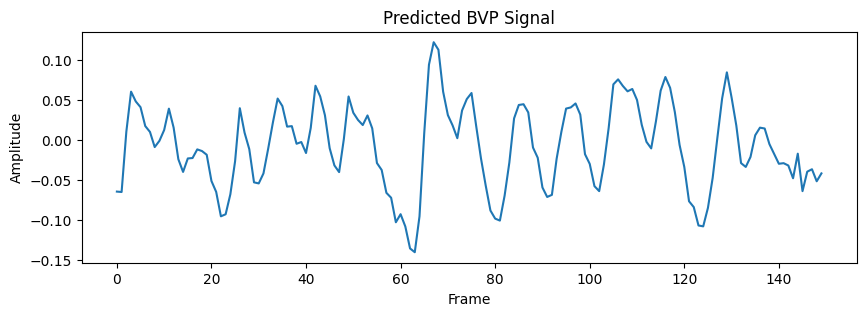

In [30]:
#run this to inference!
video_paaath="fake/fake1.mp4"
detect_deepfake(video_paaath)

In [27]:
import cv2

# Path to your video file


# Open the video file
cap = cv2.VideoCapture(video_paaath)

# Check if the video was opened successfully
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

while True:
    # Read frame-by-frame
    ret, frame = cap.read()

    # If the frame was not grabbed, we reached the end of the video
    if not ret:
        print("End of video.")
        break

    # Display the frame
    cv2.imshow('Video Player', frame)

    # Wait for 25 ms and break if 'q' is pressed
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

# Release the capture object and close windows
cap.release()
cv2.destroyAllWindows()


End of video.
